In [1]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import LinearRegression
import random

import sys

sys.path.append("..")

from utils.data_loaders import get_wake_datasets
from utils.evaluation import evaluate_model
import utils.plotting as plotting

In [2]:
FACTORS_FOLDER = "discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01"
DATA_FOLDER = f"../data/{FACTORS_FOLDER}/"
# INPUT_VAR_TO_TRAIN_REDUCTION_FACTOR = {'ti': 4, 'ct': 4}
# train_reduc_factor_string = "training_factors=" + "-".join([f"{k}{v}" for k, v in INPUT_VAR_TO_TRAIN_REDUCTION_FACTOR.items()])
INPUT_VAR_TO_TRAIN_RANGES = {"ti": [(0.15, 0.4)], "ct": [(0.3, 0.7)]}
train_range_string = "training_ranges=" + "-".join(
    [
        f"{var}{r[0]}-{r[1]}"
        for var, ranges in INPUT_VAR_TO_TRAIN_RANGES.items()
        for r in ranges
    ]
)
CONSIDER_WS = False
COORDS_AS_INPUT = True  # univariate setting

FOURIER_COMPONENTS = 32

MODEL_NAME = (
    f"univariate_approxGP_{FOURIER_COMPONENTS}fourier-components_{train_range_string}"
)
if CONSIDER_WS:
    MODEL_NAME += "_consider_ws"
MODEL_DESCRIPTION = MODEL_NAME + "_" + FACTORS_FOLDER
print(MODEL_DESCRIPTION)

univariate_approxGP_32fourier-components_training_ranges=ti0.15-0.4-ct0.3-0.7_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01


In [3]:
train_dataset, valid_dataset, test_dataset = get_wake_datasets(
    DATA_FOLDER,
    consider_ws=CONSIDER_WS,
    coords_as_input=COORDS_AS_INPUT,
    # train_perc=0.6,
    # validation_perc=0.2,
    # test_perc=0.2
    input_var_to_train_ranges=INPUT_VAR_TO_TRAIN_RANGES,
)

train_x, train_y = train_dataset.inputs, train_dataset.outputs
print("Train shapes: ", train_x.shape, train_y.shape)

"""
if valid_dataset is not None:
    valid_x, valid_y = valid_dataset.inputs, valid_dataset.outputs
    print("Valid shapes: ", valid_x.shape, valid_y.shape)
"""
del valid_dataset

grid_size = train_dataset.num_cells
print(f"{grid_size=}")

/Users/niccolomorabito/Library/CloudStorage/GoogleDrive-morabito.1808746@studenti.uniroma1.it/My Drive/BDMA/Semester4 Thesis/Ainslie-surrogate/utils/data_loaders.py:241: UserWarning: 
Ignoring percentages of train-valid-test split (train_perc=0.8, valid_perc=0, test_perc=0.2)
and using the following ranges for the training set instead:
{'ti': [(0.15, 0.4)], 'ct': [(0.3, 0.7)]}
  warnings.warn(


Train shapes:  torch.Size([7347200, 4]) torch.Size([7347200, 1])
grid_size=7168


In [4]:
rbf_sampler = RBFSampler(
    n_components=FOURIER_COMPONENTS, gamma="scale", random_state=0
)  # TODO try with 10, 100 and 1000 components
train_x_fourier = rbf_sampler.fit_transform(train_x)
print("Transformed train shape: ", train_x_fourier.shape)

Transformed train shape:  (7347200, 32)


# Training

In [5]:
model = LinearRegression()
model.fit(train_x_fourier, train_y)

LinearRegression()

In [6]:
test_x, test_y = test_dataset.inputs, test_dataset.outputs
print("Test shapes: ", test_x.shape, test_y.shape)
test_x_fourier = rbf_sampler.transform(test_x)
print("Transformed test shape: ", test_x_fourier.shape)

Test shapes:  torch.Size([27145216, 4]) torch.Size([27145216, 1])
Transformed test shape:  (27145216, 32)


In [7]:
# evaluation on trainset
evaluate_model(
    model,
    data=(train_x_fourier, train_y),
    data_type="train",
    model_description=MODEL_DESCRIPTION,
    save_results=True,
)

print("\n")

# evalution on testset
evaluate_model(
    model,
    data=(test_x_fourier, test_y),
    data_type="test",
    model_description=MODEL_DESCRIPTION,
    save_results=True,
)

Train results for univariate_approxGP_32fourier-components_training_ranges=ti0.15-0.4-ct0.3-0.7_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01
r2_score=0.5986743492979287
explained_variance_score=0.5989934206008911
mean_squared_error=0.0003646791446954012
mean_absolute_error=0.01052860077470541
median_absolute_error=0.006446704734116793
mean_absolute_percentage_error=480.4465026855469
Prediction time=1.2363896150310696e-06s


Test results for univariate_approxGP_32fourier-components_training_ranges=ti0.15-0.4-ct0.3-0.7_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01
r2_score=0.44689414410936734
explained_variance_score=0.4482032060623169
mean_squared_error=0.0006363639258779585
mean_absolute_error=0.01307645346969366
median_absolute_error=0.008035028353333473
mean_absolute_percentage_error=1649041080320.0
Prediction time=6.238078197037209e-07s


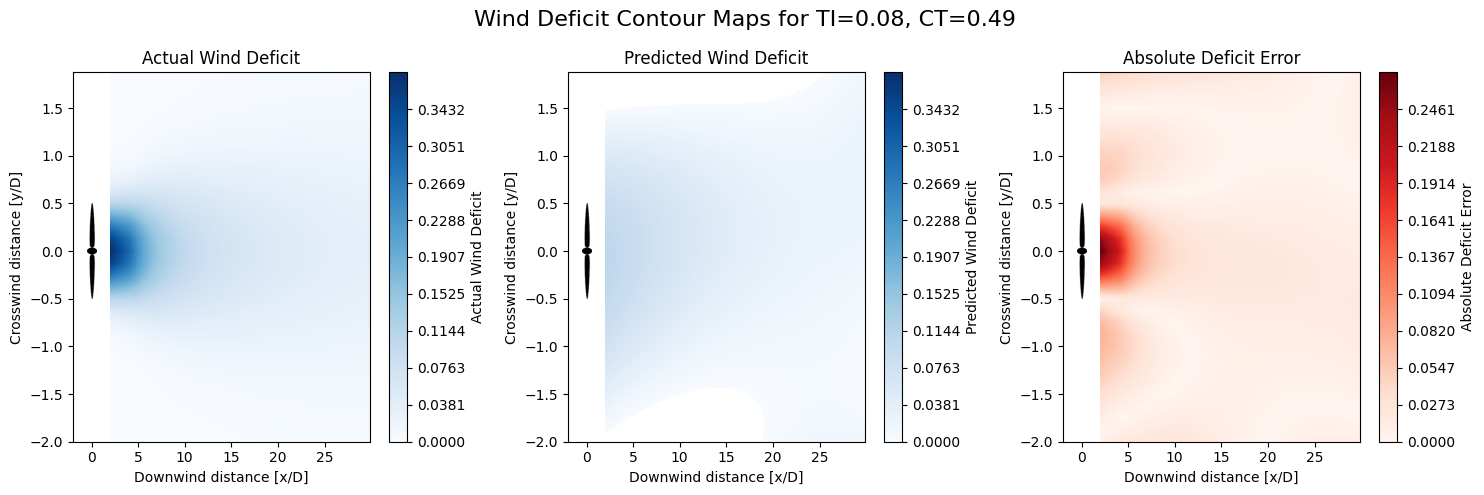

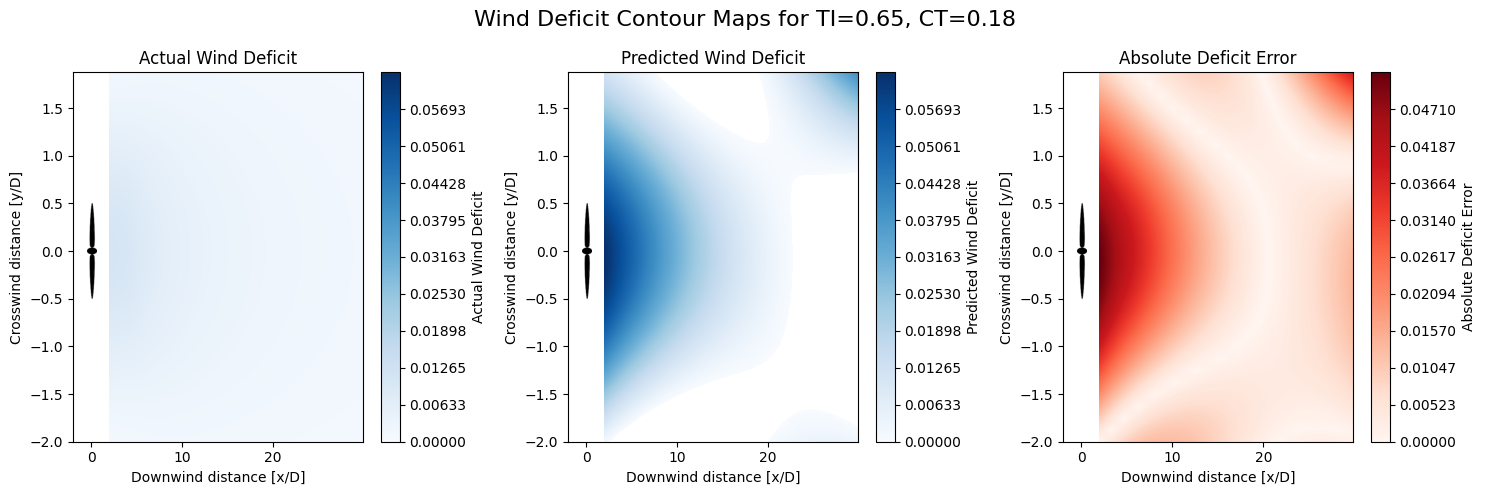

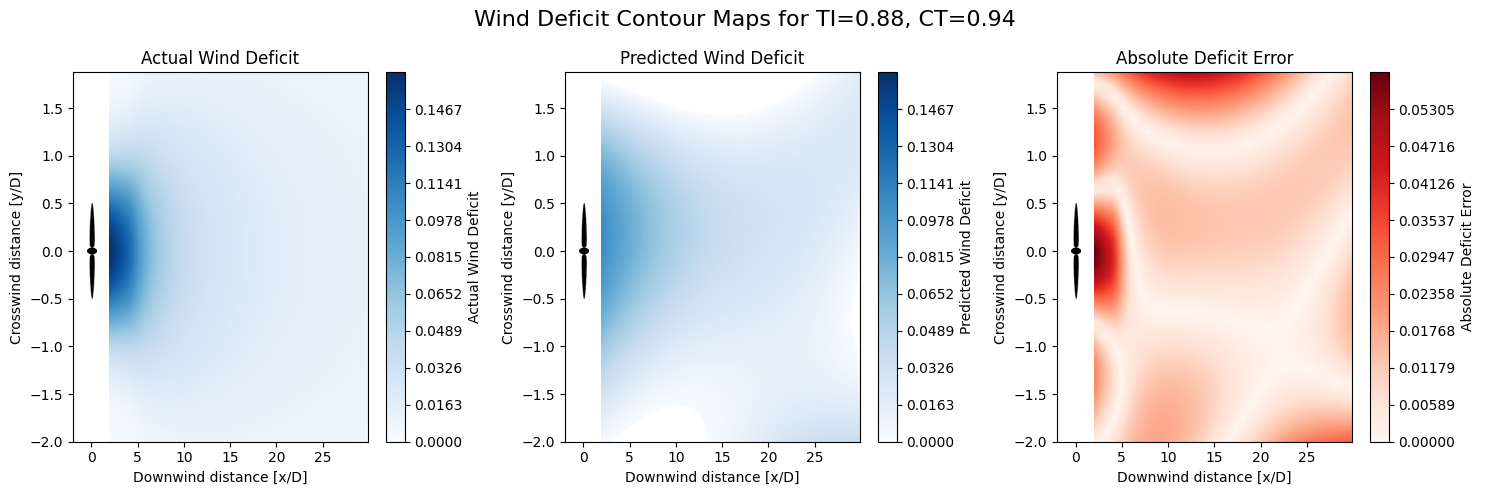

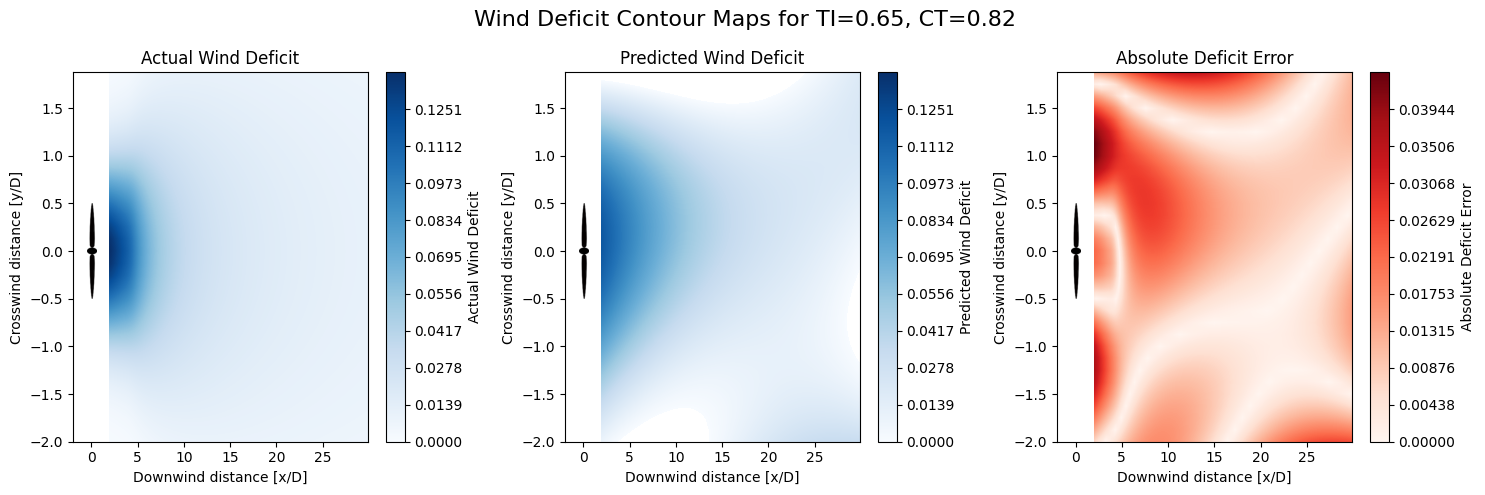

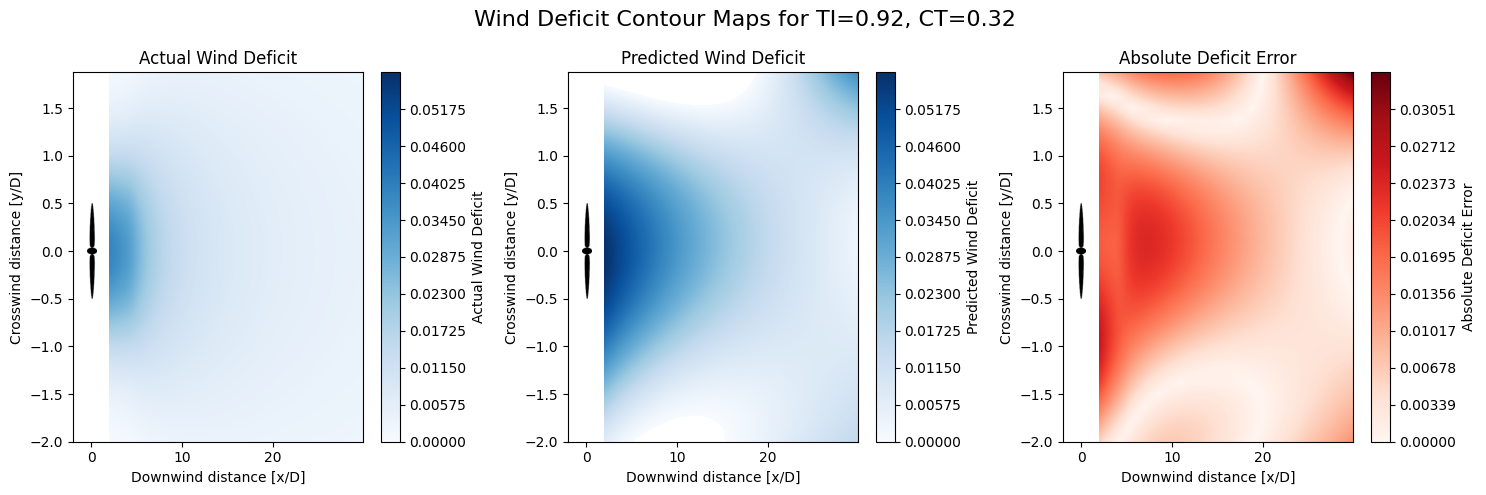

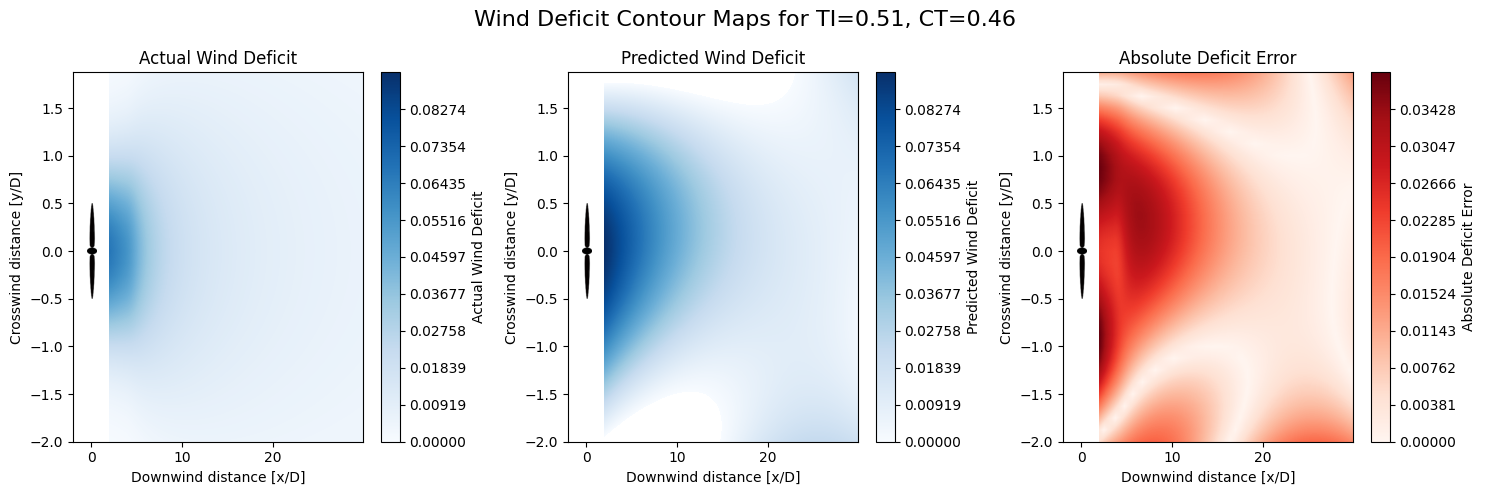

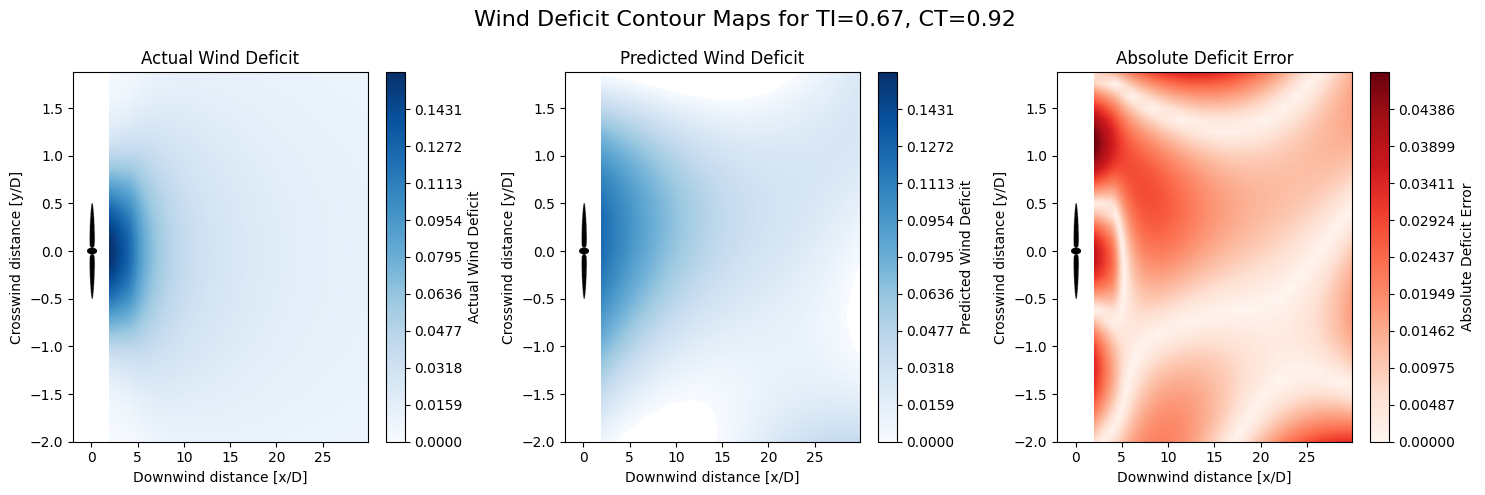

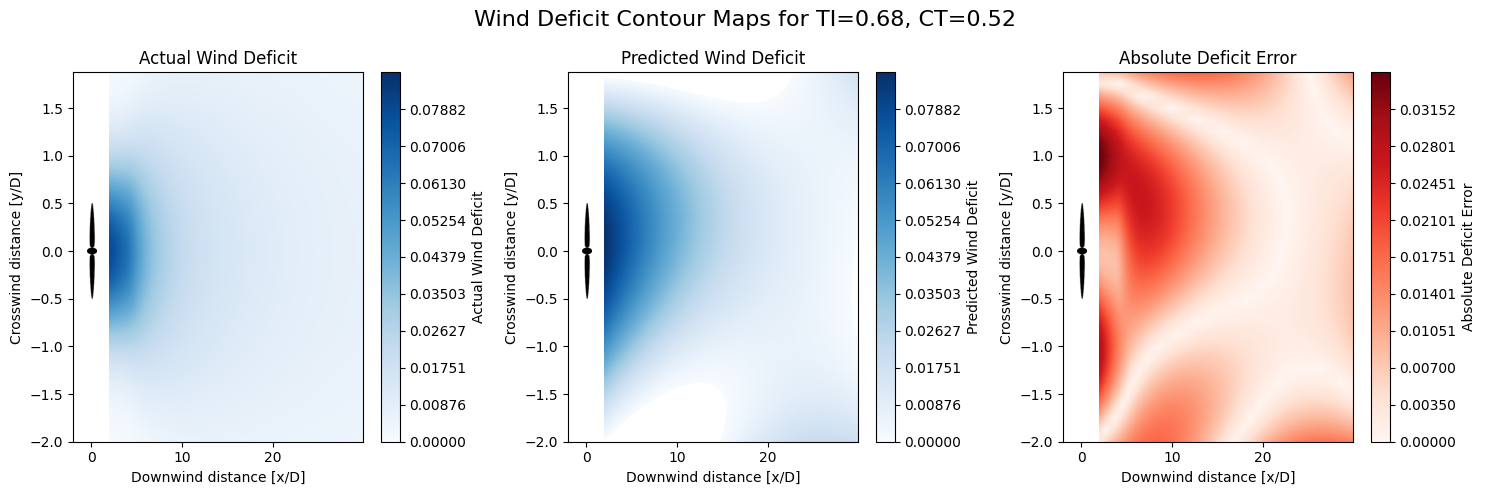

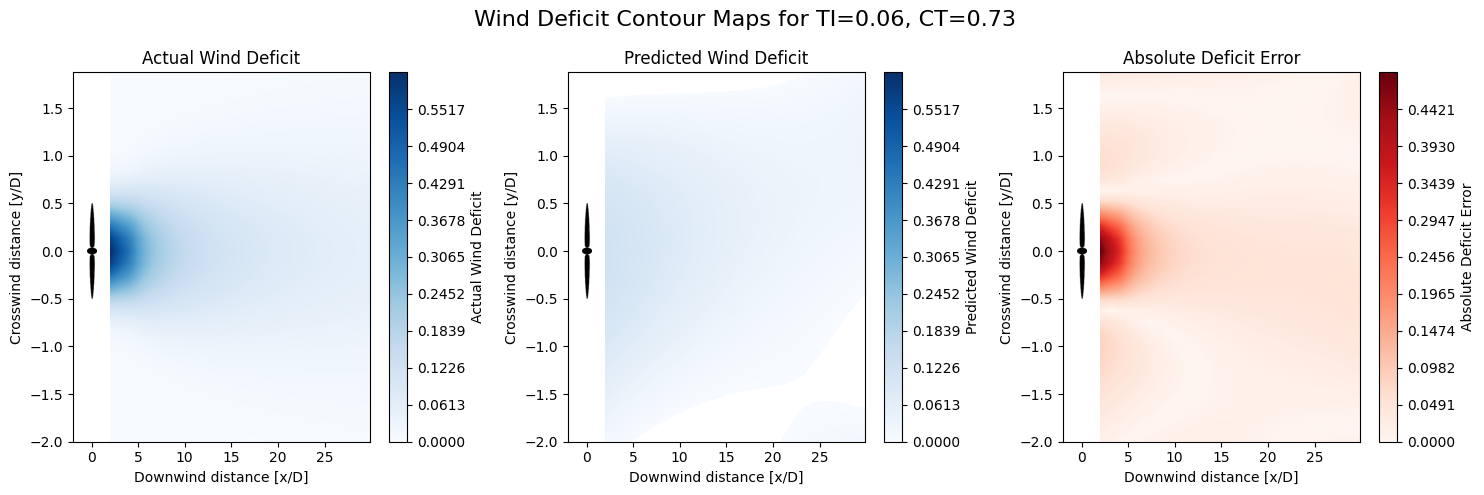

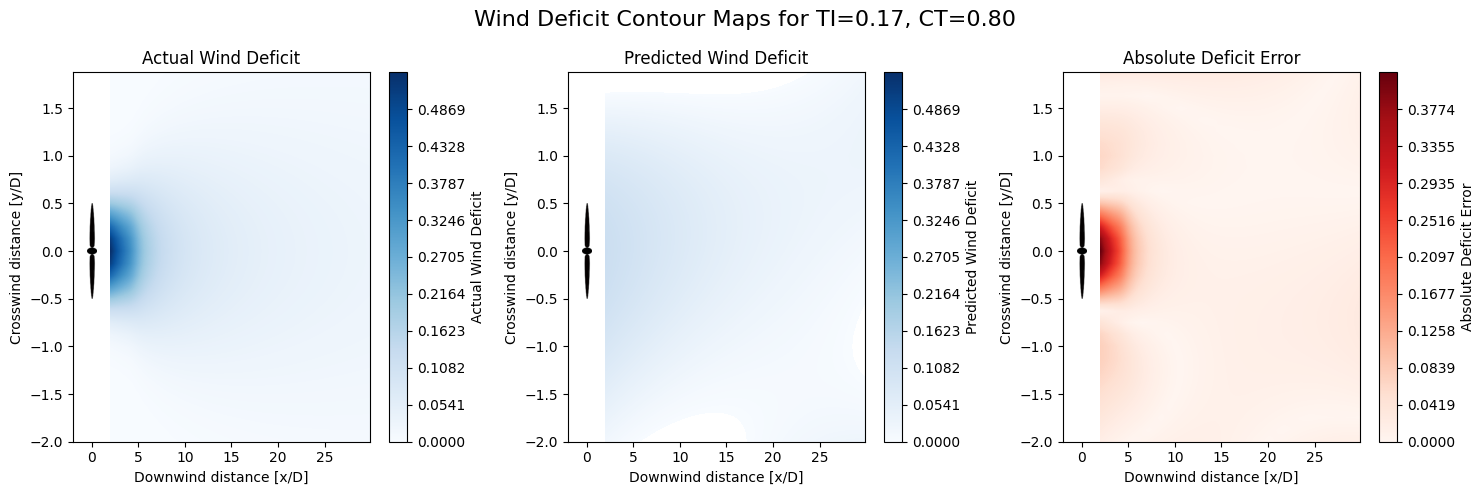

In [8]:
num_cells = test_dataset.num_cells
num_fields = len(test_dataset) // num_cells
field_indices = list(range(num_fields))
random.shuffle(field_indices)

for field_idx in field_indices[:10]:
    inputs, outputs = test_dataset[test_dataset.slice_for_field(field_idx)]
    inputs_fourier = rbf_sampler.transform(inputs)
    ti, ct, ws, wake_field, predicted_wake_field = (
        test_dataset.get_parameters_for_plotting_univariate(
            model, field_idx, transformed_inputs=inputs_fourier
        )
    )

    plotting.plot_maps(
        test_dataset.X_grid,
        test_dataset.Y_grid,
        wake_field,
        predicted_wake_field,
        ti,
        ct,
        ws,
        error_to_plot="absolute",
        add_near_wake=True,
        plot_wind_turbine=True,
    )